# Notes
- Different species
- Gap phase replacement
- Spatial field

# To-do
- Inform initial spatial and size distributions
- Inform reproductive mechanism (range, probability, etc.)
- Inform mortality mechanism
- Make the viewer more interactive (zoom and move around, play, reverse, speed up, slow down)
- ~~Write your own quadtree class and add a method for removing objects from it to speed up collision detection~~
- ~~Implement plant reproduction (either as a method in the Plant class or in the Simulation class)~~
- ~~Fix new plant spawns showing up for one frame and then getting killed~~
- ~~Add find collisions to Simulation class~~
- ~~Move plants list and states list to Simulation class~~
- ~~Fix Plant .kill() method~~
- ~~replace .update_color() method to set_color() in Plant class~~
- ~~add simulation.step() method to Simulation class~~

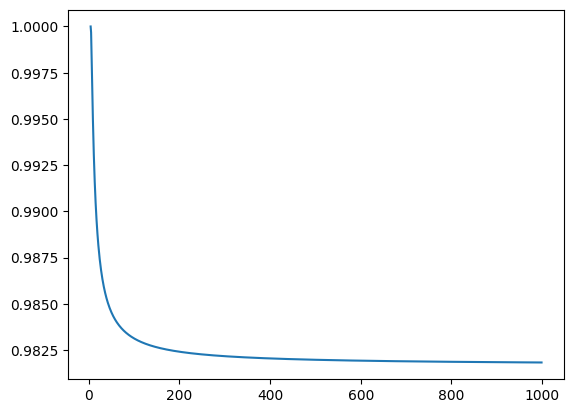

In [29]:
import numpy as np
import matplotlib.pyplot as plt

age_max = np.arange(4, 1000)
prob_mort = 1 - (1 - 4/age_max)**age_max

plt.plot(age_max, prob_mort)